In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

from torchvision.utils import save_image

# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上运行，这里假设使用序号为0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 在当前目录，创建不存在的目录ave_samples
sample_dir = 'vae_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    
# 定义一些超参数
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 30
batch_size = 128
learning_rate = 0.001

# 下载MNIST训练集，这里因已下载，故download=False
dataset = torchvision.datasets.MNIST(root='data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=False)

## 数据加载
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size,
                                         shuffle=True)


In [8]:
## 定义VAE模型
class VAE(nn.Module):
    def __init__(self, image_size=784,h_dim=400,z_dim=20):
        super(VAE,self).__init__()
        self.fc1 = nn.Linear(image_size,h_dim)
        self.fc2 = nn.Linear(h_dim,z_dim)
        self.fc3 = nn.Linear(h_dim,z_dim)
        self.fc4 = nn.Linear(z_dim,h_dim)
        self.fc5 = nn.Linear(h_dim,image_size)
        
    def encode(self,x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self,mu,log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu+eps*std
    
    def decode(self,z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self,x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu,log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
    
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# 开始训练模型
for epoch in range(num_epochs):
    model.train()
    for i, (x,_) in enumerate(data_loader):
        # 前向传播
        model.zero_grad()
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        ## compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        

        ## 反向传播哦及优化器
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i+1) % 100 == 0:
            print("Epoch[{}/{}],Step[{},{}],Reconst Loss: {:.4f}, KL Div: {:.4f}"
                 .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(),kl_div.item()))
        
        
    with torch.no_grad():
        # 保存采样图像，即潜在向量Z通过解码器生成新的图像
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1,1,28,28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        
        # 保存重构图像，即原图像通过解码器生成的图像
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1,1,28,28),out.view(-1,1,28,28)],dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))


Epoch[1/30],Step[100,469],Reconst Loss: 22890.9180, KL Div: 1413.9302
Epoch[1/30],Step[200,469],Reconst Loss: 18148.7891, KL Div: 1901.0647
Epoch[1/30],Step[300,469],Reconst Loss: 15787.6338, KL Div: 2269.0381
Epoch[1/30],Step[400,469],Reconst Loss: 14475.8770, KL Div: 2491.3176
Epoch[2/30],Step[100,469],Reconst Loss: 13129.1992, KL Div: 2782.4370
Epoch[2/30],Step[200,469],Reconst Loss: 12587.5078, KL Div: 2941.1790
Epoch[2/30],Step[300,469],Reconst Loss: 12821.3320, KL Div: 2948.8901
Epoch[2/30],Step[400,469],Reconst Loss: 11633.4277, KL Div: 2937.0381
Epoch[3/30],Step[100,469],Reconst Loss: 11392.7617, KL Div: 2952.9978
Epoch[3/30],Step[200,469],Reconst Loss: 11208.6602, KL Div: 2952.3076
Epoch[3/30],Step[300,469],Reconst Loss: 11456.0146, KL Div: 3080.6992
Epoch[3/30],Step[400,469],Reconst Loss: 11872.0527, KL Div: 3083.5068
Epoch[4/30],Step[100,469],Reconst Loss: 10847.1426, KL Div: 3174.1707
Epoch[4/30],Step[200,469],Reconst Loss: 11034.2754, KL Div: 3202.2734
Epoch[4/30],Step[300

Epoch[30/30],Step[200,469],Reconst Loss: 9965.0264, KL Div: 3302.5166
Epoch[30/30],Step[300,469],Reconst Loss: 9849.3887, KL Div: 3201.3372
Epoch[30/30],Step[400,469],Reconst Loss: 9884.0469, KL Div: 3175.0342


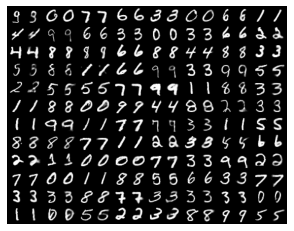

In [18]:
reconsPath = './vae_samples/reconst-30.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

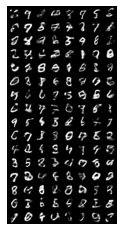

In [19]:
genPath = './vae_samples/sampled-30.png'
Image = mpimg.imread(genPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()